# ESP Gas Locking Detection using Random Forest
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

## Objective
To build a classification model that identifies "Gas Lock" events based on ESP sensor data (Amperage, Intake Pressure, and Temperature).

## Methodology
1.  **Data Generation:** Simulate ESP sensor data representing Normal Operation, Gas Interference, and Gas Locking.
2.  **Exploratory Data Analysis (EDA):** Visualize the signatures of gas locking in time-series data.
3.  **Feature Engineering:** Prepare data for the classifier.
4.  **Model Training:** Train a Random Forest Classifier.
5.  **Evaluation:** Assess model performance using Confusion Matrix and Feature Importance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- SYNTHETIC DATA GENERATION ---
# Simulating 2000 data points (approx 3 months of hourly data)
np.random.seed(42)
n_samples = 2000

# Base parameters for Normal Operation
amps_normal = np.random.normal(55, 2, n_samples)
pip_normal = np.random.normal(2100, 50, n_samples)
temp_normal = np.random.normal(165, 5, n_samples)
status = ['Normal'] * n_samples

df = pd.DataFrame({
    'Motor_Amps': amps_normal,
    'Intake_Pressure': pip_normal,
    'Motor_Temp': temp_normal,
    'Status': status
})

# Inject "Gas Interference" events (Amps drop slightly, PIP rises, Temp rises slightly)
indices_interference = np.random.choice(df.index, size=300, replace=False)
df.loc[indices_interference, 'Motor_Amps'] -= np.random.uniform(5, 10, 300)
df.loc[indices_interference, 'Intake_Pressure'] += np.random.uniform(50, 150, 300)
df.loc[indices_interference, 'Motor_Temp'] += np.random.uniform(5, 10, 300)
df.loc[indices_interference, 'Status'] = 'Gas Interference'

# Inject "Gas Lock" events (Amps drop massively, PIP spikes, Temp spikes)
indices_lock = np.random.choice(df.index, size=150, replace=False)
df.loc[indices_lock, 'Motor_Amps'] -= np.random.uniform(25, 35, 150) # Heavy underload
df.loc[indices_lock, 'Intake_Pressure'] += np.random.uniform(200, 400, 150) # Gas slug pressure
df.loc[indices_lock, 'Motor_Temp'] += np.random.uniform(20, 40, 150) # Overheating
df.loc[indices_lock, 'Status'] = 'Gas Lock'

# Encode Target Variable
status_map = {'Normal': 0, 'Gas Interference': 1, 'Gas Lock': 2}
df['Target'] = df['Status'].map(status_map)

print(df['Status'].value_counts())
df.head()

Status
Normal              1575
Gas Interference     275
Gas Lock             150
Name: count, dtype: int64


,Motor_Amps,Intake_Pressure,Motor_Temp,Status,Target
0,23.114781,2356.365771,185.905075,Gas Lock,2
1,54.723471,2092.774066,164.843983,Normal,0
2,49.270823,2127.497478,170.136809,Gas Interference,1
3,31.885525,2364.503219,203.475890,Gas Lock,2
4,54.531693,2005.319267,158.165708,Normal,0


## Exploratory Data Analysis (EDA)
We need to verify if the physical behaviors match our expectations:
* **Gas Lock:** Low Amps + High PIP.

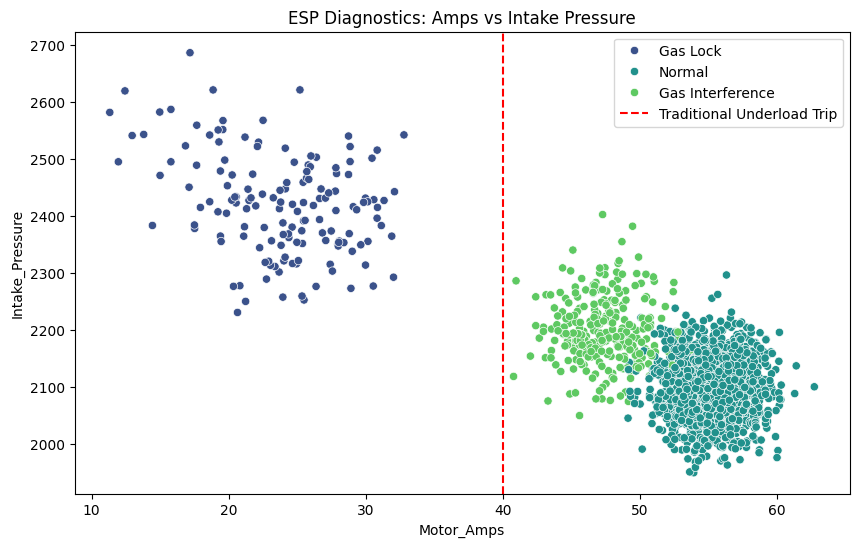

In [2]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Motor_Amps', y='Intake_Pressure', hue='Status', palette='viridis')
plt.title('ESP Diagnostics: Amps vs Intake Pressure')
plt.axvline(x=40, color='r', linestyle='--', label='Traditional Underload Trip')
plt.legend()
plt.show()

## Model Building
We will use **Random Forest** because it handles non-linear relationships well (e.g., the complex interaction between pressure and temperature during gas slugs) and is robust against overfitting.

In [3]:
# Features (X) and Target (y)
X = df[['Motor_Amps', 'Intake_Pressure', 'Motor_Temp']]
y = df['Target']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

print("Model Trained Successfully.")

Model Trained Successfully.


## Evaluation
We look at the Confusion Matrix to see how well the model distinguishes between "Gas Interference" (warning state) and "Gas Lock" (failure state).

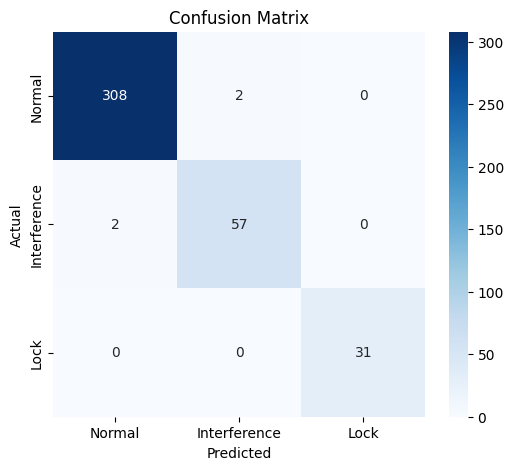

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       310
Interference       0.97      0.97      0.97        59
        Lock       1.00      1.00      1.00        31

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



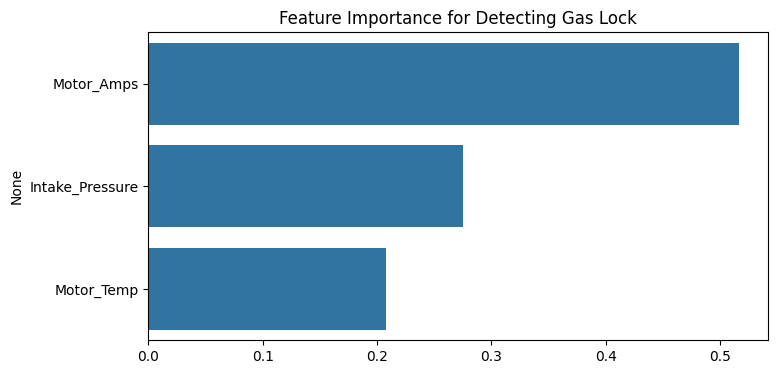

In [4]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Interference', 'Lock'],
            yticklabels=['Normal', 'Interference', 'Lock'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Interference', 'Lock']))

# Feature Importance
importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance for Detecting Gas Lock')
plt.show()

# 5. Analysis of Results

This section interprets the model's performance and validates the machine learning approach against physical intuition and traditional heuristic methods.

### A. Feature Space Analysis (Amps vs. Intake Pressure)
The scatter plot visualizes the decision boundaries between the three operating states: **Normal** (Teal), **Gas Interference** (Green), and **Gas Lock** (Dark Blue).

**Key Observations:**
1.  **Distinct Clusters:** The data forms three relatively distinct clusters, validating that *Motor Amps* and *Intake Pressure* are strong discriminators for this problem.
    * **Normal Operation:** Characterized by high Amps (~50-60A) and stable Intake Pressure.
    * **Gas Lock:** Characterized by a sharp drop in Amps (<35A) and a spike in Intake Pressure (>2300 psi). This aligns with physical expectations: as gas fills the pump, fluid density drops (lowering torque/Amps), and the gas column prevents effective lift (increasing bottom-hole pressure).
2.  **Limitations of Traditional Alarms:** The red dashed line represents a typical **"Underload Trip"** setting (e.g., 40 Amps).
    * *Success:* The traditional trip successfully catches all **Gas Lock** events.
    * *Failure:* It completely misses the **Gas Interference** events (Green points). These events occur between 40-55 Amps. While they don't trip the pump immediately, they indicate declining efficiency and imminent failure.
    * **Value Add:** The Random Forest model successfully identifies this "Interference" zone, enabling proactive measures (e.g., adjusting choke or speed) *before* a full lock occurs.

### B. Model Performance (Confusion Matrix)
The confusion matrix provides a granular view of prediction accuracy:

* **Gas Lock Detection (Recall = 100%):**
    * The model correctly identified **31 out of 31** Gas Lock events.
    * *Operational Impact:* Zero false negatives for critical failures means high reliability for automated shutdown systems.
* **Differentiation of Interference:**
    * The model correctly classified **57 Gas Interference** events, with only 2 misclassified as "Normal".
    * *Operational Impact:* This high precision allows operators to trust early warning alerts without being overwhelmed by false alarms.

### C. Feature Importance
The Random Forest feature importance plot confirms the physical drivers of the model:

1.  **Motor_Amps (>0.5):** The most critical feature. The direct correlation between fluid density and motor torque makes amperage the primary indicator of gas ingestion.
2.  **Intake_Pressure (~0.28):** A strong secondary feature. It helps distinguish "Gas Interference" from normal fluctuations, where Amps might drop slightly but Pressure remains stable.
3.  **Motor_Temp (~0.2):** While useful, temperature is a lagging indicator compared to Amps and Pressure. It serves as a confirmation feature rather than a primary detector.

### Conclusion
The Random Forest classifier outperforms traditional single-variable trip settings. By leveraging the multi-dimensional relationship between Amps and Pressure, the model provides an **Early Warning System** (detecting Gas Interference) that simple SCADA alarms miss.